In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'D:/datasets/face_expressions/train'
TEST_DIR = 'D:/datasets/face_expressions/test'
IMG_SIZE = 50
LR = 0.00025

MODEL_NAME = 'face_expression-{}-{}.model'.format(LR, '8conv-basic-video')

In [17]:
def get_path():
    # /angry/Training_3908 ...
    expressions = os.listdir(TRAIN_DIR)
    paths = []
    for derectory in expressions:
        path = str(TRAIN_DIR +'/' + derectory)
        paths.append(path)
    return paths

directories = get_path()

In [18]:
directories

['D:/datasets/face_expressions/train/angry',
 'D:/datasets/face_expressions/train/disgust',
 'D:/datasets/face_expressions/train/fear',
 'D:/datasets/face_expressions/train/happy',
 'D:/datasets/face_expressions/train/neutral',
 'D:/datasets/face_expressions/train/sad',
 'D:/datasets/face_expressions/train/surprise']

In [27]:
def label_img(expression):
    expressions = os.listdir(TRAIN_DIR)
    if expression == expressions[0] : return np.array([1,0,0,0,0,0,0], dtype=float)
    elif expression == expressions[1]: return np.array([0,1,0,0,0,0,0], dtype=float)
    elif expression == expressions[2]: return np.array([0,0,1,0,0,0,0], dtype=float)
    elif expression == expressions[3]: return np.array([0,0,0,1,0,0,0], dtype=float)
    elif expression == expressions[4]: return np.array([0,0,0,0,1,0,0], dtype=float)
    elif expression == expressions[5]: return np.array([0,0,0,0,0,1,0], dtype=float)
    elif expression == expressions[6]: return np.array([0,0,0,0,0,0,1], dtype=float)

label_img('surprise')

array([0., 0., 0., 0., 0., 0., 1.])

In [28]:
def create_train_data():
    training_data = []
    
    # directories : 'D:/datasets/face_expressions/train/angry', 'D:/datasets/face_expressions/train/sad'...
    for derectory in directories:
        for img in tqdm(os.listdir(derectory)):
            # 'angry', 'happy' ...
            expression = derectory.split('/')[-1]
            # one-hot-encoding
            label = label_img(expression)
            path = os.path.join(derectory,img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            training_data.append([np.array(img, dtype=float), label])
            
    shuffle(training_data)
    np.save('train_data_expressions.npy', training_data)
    return training_data

In [29]:
# 봉인!
# train_data = create_train_data()
train_data = np.load('train_data.npy', allow_pickle=True)

100%|██████████| 3171/3171 [00:17<00:00, 179.45it/s]
C:\Users\ghdak\anaconda3\envs\dl\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [2]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], dtype=float, name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 10, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 10, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.5)

convnet = fully_connected(convnet, 7, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [72]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('mpdel loaded!')

In [73]:
train = train_data[:-500]
test = train_data[-500:]

In [74]:
X = np.array([i[0] for i in train], dtype=float).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train], dtype=float)

test_x = np.array([i[0] for i in test], dtype=float).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test], dtype=float)

In [75]:
Y.shape

(28209, 7)

In [86]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 4409  | total loss: 0.60041 | time: 16.755s
| Adam | epoch: 010 | loss: 0.60041 - acc: 0.7959 -- iter: 28160/28209
Training Step: 4410  | total loss: 0.59632 | time: 17.802s
| Adam | epoch: 010 | loss: 0.59632 - acc: 0.7960 | val_loss: 2.02091 - val_acc: 0.4800 -- iter: 28209/28209
--


In [87]:
# tensorboard --logdir=C:\Users\ghdak\Desktop\Data_science\kaggle\face_expressions\log  (anaconda prompt)

In [88]:
model.save(MODEL_NAME)

INFO:tensorflow:c:\Users\ghdak\Desktop\Data_science\kaggle\face_expressions\face_expression-0.00025-8conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


In [95]:
def get_test_path():
    # /angry/Training_3908 ...
    expressions = os.listdir(TEST_DIR)
    paths = []
    for derectory in expressions:
        path = str(TEST_DIR +'/' + derectory)
        paths.append(path)
    return paths

directories_test = get_test_path()
directories_test

['D:/datasets/face_expressions/test/angry',
 'D:/datasets/face_expressions/test/disgust',
 'D:/datasets/face_expressions/test/fear',
 'D:/datasets/face_expressions/test/happy',
 'D:/datasets/face_expressions/test/neutral',
 'D:/datasets/face_expressions/test/sad',
 'D:/datasets/face_expressions/test/surprise']

In [96]:
def process_test_data():
    testing_data = []
    expressions = os.listdir(TEST_DIR)
    # directories : 'D:/datasets/face_expressions/train/angry', 'D:/datasets/face_expressions/train/sad'...
    for derectory in directories_test:
        for img in tqdm(os.listdir(derectory)):
            # 'angry', 'happy' ...
            expression = derectory.split('/')[-1]
            # one-hot-encoding
            label = label_img(expression)
            path = os.path.join(derectory,img)
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
            testing_data.append([np.array(img, dtype=float), label])
            
    shuffle(testing_data)
    np.save('test_data_expressions.npy', testing_data)
    return testing_data

In [97]:
# test_data = process_test_data
test_data = process_test_data()

100%|██████████| 831/831 [00:04<00:00, 175.75it/s]
C:\Users\ghdak\anaconda3\envs\dl\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [103]:
pred_x = np.array([i[0] for i in test_data], dtype=float).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
back_y = np.array([i[1] for i in test_data], dtype=float)

In [102]:
pred_y = model.predict(pred_x)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(back_y, pred_y)
round(mae, 2)

In [3]:
model.load(MODEL_NAME, weights_only=True)  #transfer the weights of the first model

INFO:tensorflow:Restoring parameters from c:\Users\ghdak\Desktop\Data_science\kaggle\face_expressions\face_expression-0.00025-8conv-basic-video.model


In [16]:
expressions = ['화난', '혐오하는', '공포스러운', '행복한', '무표정의', '슬픈', '놀란']
def predict(example):
    result = model.predict(example)[0]   
    total = {expressions[i] : result[i] * 100 for i in range(7)}
    if max(result) == result[0]: return expressions[0], total
    elif max(result) == result[1]: return expressions[1], total
    elif max(result) == result[2]: return expressions[2], total
    elif max(result) == result[3]: return expressions[3], total
    elif max(result) == result[4]: return expressions[4], total
    elif max(result) == result[5]: return expressions[5], total
    elif max(result) == result[6]: return expressions[6], total
    

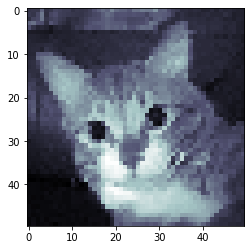

화난
{'공포스러운': 19.45677250623703,
 '놀란': 0.07203398854471743,
 '무표정의': 0.3194390796124935,
 '슬픈': 7.99831822514534,
 '행복한': 0.17783261137083173,
 '혐오하는': 2.2861426696181297,
 '화난': 69.68945860862732}


In [19]:
import matplotlib.pyplot as plt
import pprint
img_ex = cv2.resize(cv2.imread('test4.jpg', cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
example = np.array(img_ex, dtype=float).reshape((1, IMG_SIZE, IMG_SIZE, 1))
plt.imshow(img_ex, cmap=plt.cm.bone)
plt.show()
print(predict(example)[0])
pprint.pprint(predict(example)[1])

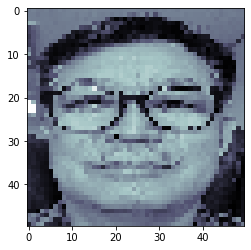

행복한
{'공포스러운': 0.002705305814743042,
 '놀란': 0.0018214082956546918,
 '무표정의': 0.44345464557409286,
 '슬픈': 0.24962706957012415,
 '행복한': 99.19920563697815,
 '혐오하는': 8.983796533357236e-05,
 '화난': 0.10309892240911722}


In [7]:
img_ex = cv2.resize(cv2.imread('test10.jpg', cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
example = np.array(img_ex, dtype=float).reshape((1, IMG_SIZE, IMG_SIZE, 1))
plt.imshow(img_ex, cmap=plt.cm.bone)
plt.show()
print(predict(example)[0])
pprint.pprint(predict(example)[1])

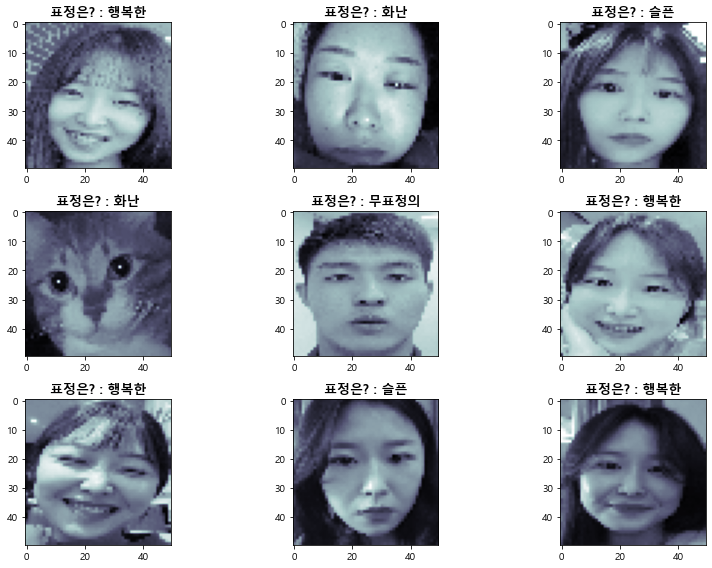

In [54]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    pic = 'test' + str(i+1) + '.jpg'
    img_ex = cv2.resize(cv2.imread(pic, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    example = np.array(img_ex, dtype=float).reshape((1, IMG_SIZE, IMG_SIZE, 1))
    plt.imshow(img_ex, cmap=plt.cm.bone)
    plt.title(f'표정은? : {predict(example)[0]}', size=13, fontweight="bold")
       
plt.tight_layout()
plt.show()    